<a href="https://colab.research.google.com/github/dgamorimm/gans-colab/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN - Deep Convolutional GANs

# Importação das bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.12.0'

# Carregamento e pré-processamento da base de dados

In [ ]:
(X_treinamento, y_treinamento), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
X_treinamento.shape

(60000, 28, 28)

In [ ]:
28 * 28

784

In [ ]:
y_treinamento.shape

(60000,)

0


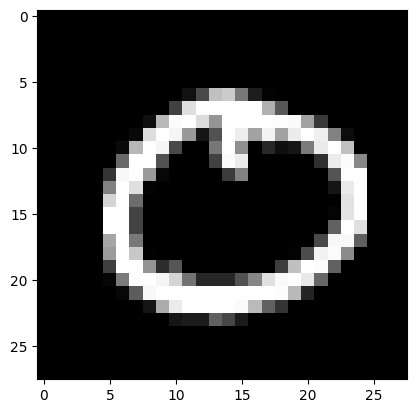

In [ ]:
i = np.random.randint(0, 60000)
#print(i)
print(y_treinamento[i])
plt.imshow(X_treinamento[i], cmap = 'gray');

In [ ]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_treinamento.shape

(60000, 28, 28, 1)

In [ ]:
X_treinamento[0].min(), X_treinamento[0].max()

(0.0, 255.0)

In [ ]:
X_treinamento = (X_treinamento - 127.5) / 127.5

In [ ]:
X_treinamento[0].min(), X_treinamento[0].max()

(-1.0, 1.0)

In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
buffer_size / batch_size

234.375

In [ ]:
type(X_treinamento)

numpy.ndarray

In [ ]:
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

In [ ]:
type(X_treinamento)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
X_treinamento

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Construção do gerador

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Funções de ativação: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [ ]:
7*7*256

12544

In [ ]:
def cria_gerador():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size=(5,5), padding='same',use_bias=False, strides=(2,2), activation = 'tanh'))

  network.summary()

  return network

In [ ]:
gerador = cria_gerador()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
# 100 -> 12544
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [ ]:
ruido = tf.random.normal([1, 100])
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.0452873 , -1.1768881 ,  0.27577323,  1.4245833 ,  0.52557564,
        -0.49847114,  1.4689559 ,  0.39158812, -0.22114396, -1.40723   ,
         2.8084505 , -2.154227  ,  0.5594954 , -0.5265679 , -0.8384037 ,
        -0.2150964 ,  1.5484622 ,  1.1523452 ,  0.69649285,  0.725854  ,
         0.4988998 , -0.6687993 ,  0.9770288 ,  2.4378138 ,  0.267039  ,
        -0.07336116, -0.29329813, -0.07627656, -0.92674553,  1.4339724 ,
        -0.33388135,  2.6203036 ,  1.0386171 , -0.71021026, -0.696257  ,
         1.0151281 ,  0.6513816 ,  0.20722894,  0.37457126,  0.2572192 ,
        -1.6521604 , -0.31780782, -0.62156373, -0.695206  ,  1.2086354 ,
        -0.88234   , -2.2835865 , -0.20336203,  1.1530105 ,  0.07470815,
        -0.3716307 ,  0.1197166 ,  0.47453174,  0.7938292 ,  1.6543736 ,
        -1.6082836 ,  0.4009694 ,  0.3694137 ,  0.68382424, -0.28148904,
         0.6842111 , -0.76479834,  0.5847659 , -1.8832848 ,  0.03216288,
 

In [ ]:
imagem_gerada = gerador(ruido, training = False)

In [ ]:
imagem_gerada.shape

TensorShape([1, 28, 28, 1])

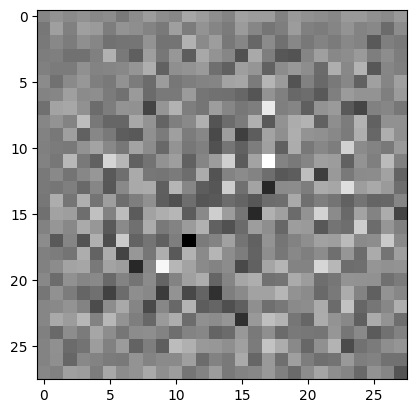

In [ ]:
plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray');

# Construção do discriminador

- Dropout: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
- Conv2d x Conv2dTranspose: https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d

In [ ]:
def cria_discriminador():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides=(2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides=(2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [ ]:
7 * 7 * 128

6272

In [ ]:
discriminador = cria_discriminador()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
discriminador.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [ ]:
discriminador(imagem_gerada, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00054028]], dtype=float32)>

In [ ]:
tf.sigmoid(0.00356018)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5008901>

# Cálculo do erro

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

Este método quantifica quão bem o discriminador é capaz de distinguir imagens reais de falsificações. Ele compara as previsões do discriminador em imagens reais com uma matriz de 1s e as previsões do discriminador em imagens falsas (geradas) com uma matriz de 0s.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
tf.ones_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [ ]:
tf.zeros_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [ ]:
def discriminador_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def gerador_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Treinamento da GAN e visualização dos resultados

- Adaptado de: https://www.tensorflow.org/beta/tutorials/generative/dcgan
- @tf.function: https://www.tensorflow.org/guide/function#:~:text=You%20can%20use%20tf.,is%20required%20to%20use%20SavedModel%20.

In [ ]:
X_treinamento

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
epocas = 100
dimensao_ruido = 100
numero_imagens = 16

In [ ]:
batch_size, dimensao_ruido

(256, 100)

In [ ]:
@tf.function
def treinamento(imagens):
  ruido = tf.random.normal([batch_size, dimensao_ruido])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    imagens_geradas = gerador(ruido, training = True)

    expected_output = discriminador(imagens, training = True)
    fake_output = discriminador(imagens_geradas, training = True)

    gen_loss = gerador_loss(fake_output)
    disc_loss = discriminador_loss(expected_output, fake_output)

  gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
  gradientes_discriminador = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

  gerador_optimizer.apply_gradients(zip(gradientes_gerador, gerador.trainable_variables))
  discriminador_optimizer.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

In [ ]:
imagens_teste = tf.random.normal([numero_imagens, dimensao_ruido])
imagens_teste.shape

TensorShape([16, 100])

In [ ]:
60000 / 256

234.375

In [ ]:
def treina_gan(dataset, epocas, imagens_teste):
  for epoca in range(epocas):
    for imagem_batch in dataset:
      #print(imagem_batch.shape)
      treinamento(imagem_batch)

    print('Época: ', epoca + 1)
    imagens_geradas = gerador(imagens_teste, training=False)
    fig = plt.figure(figsize = (10,10))
    for i in range(imagens_geradas.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(imagens_geradas[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
      plt.axis('off')
    plt.show()

Época:  1


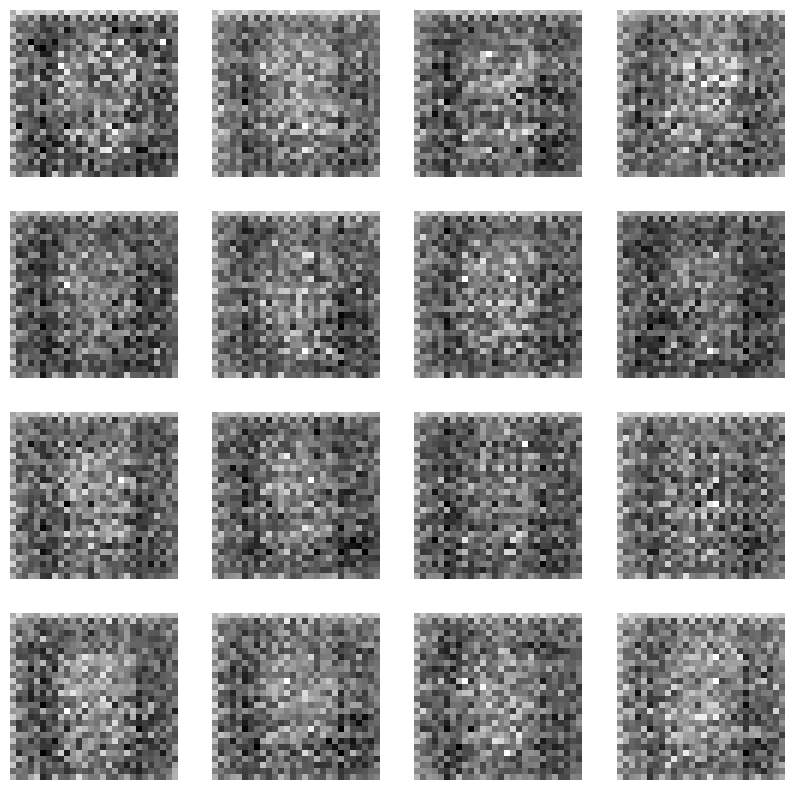

Época:  2


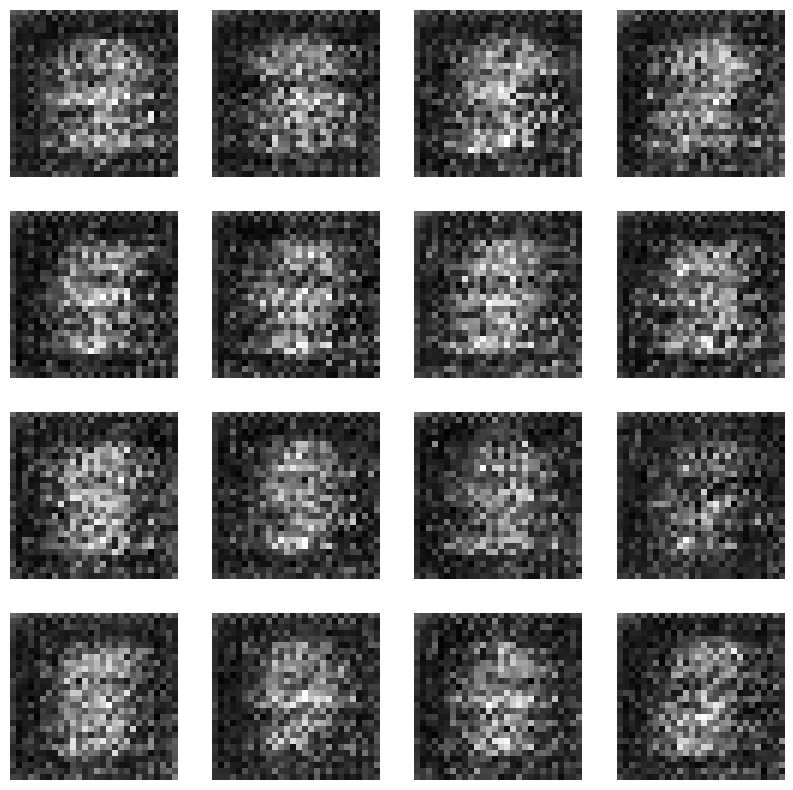

Época:  3


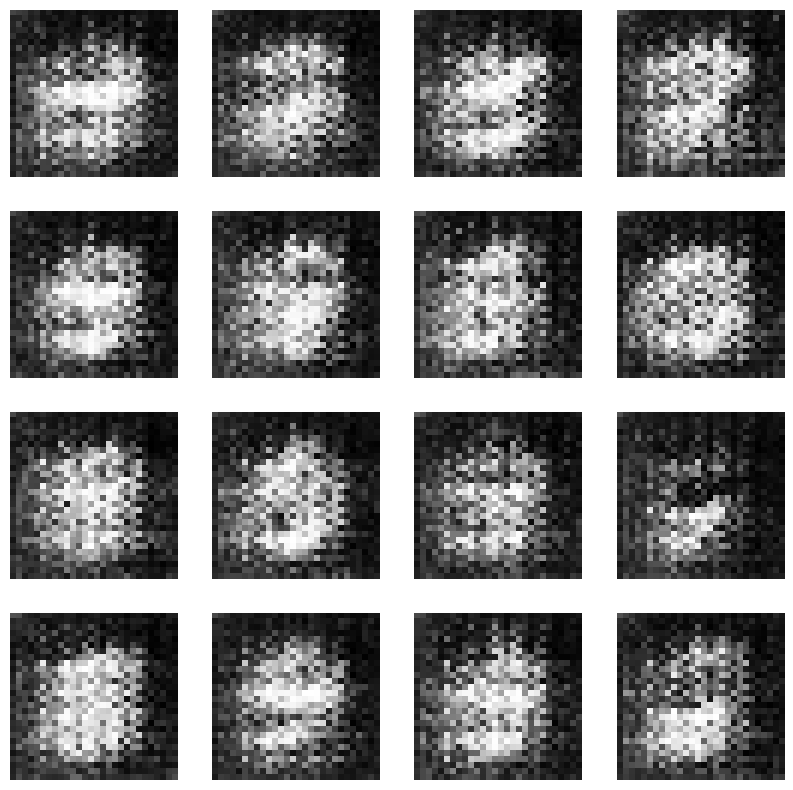

Época:  4


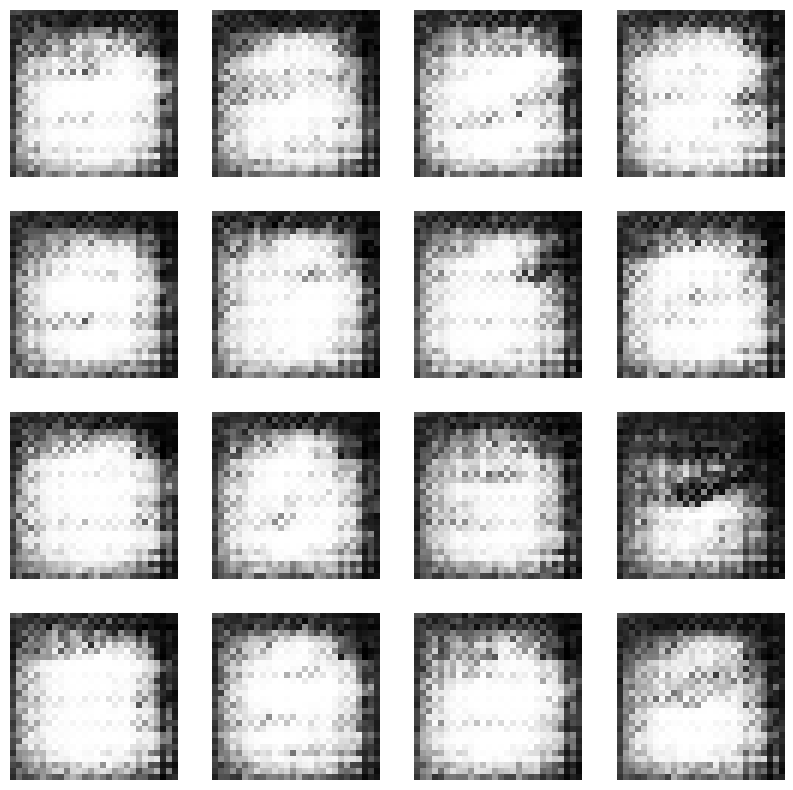

Época:  5


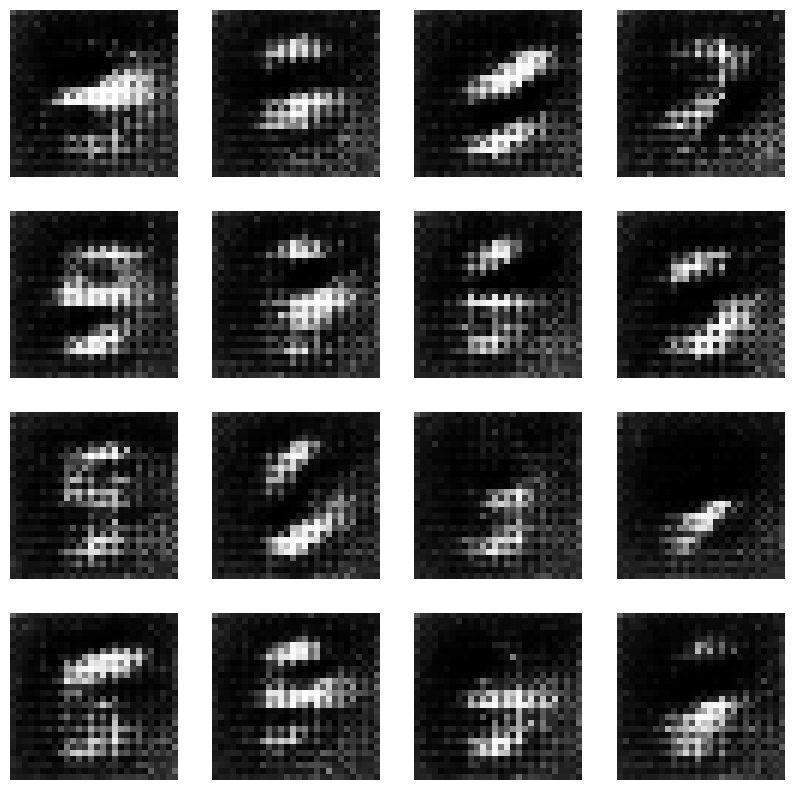

Época:  6


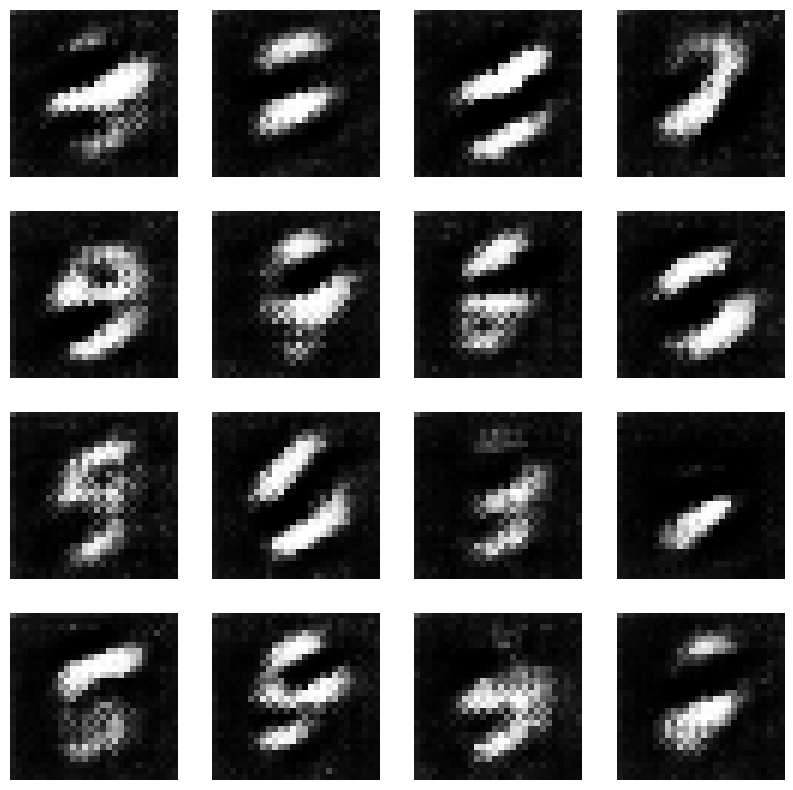

Época:  7


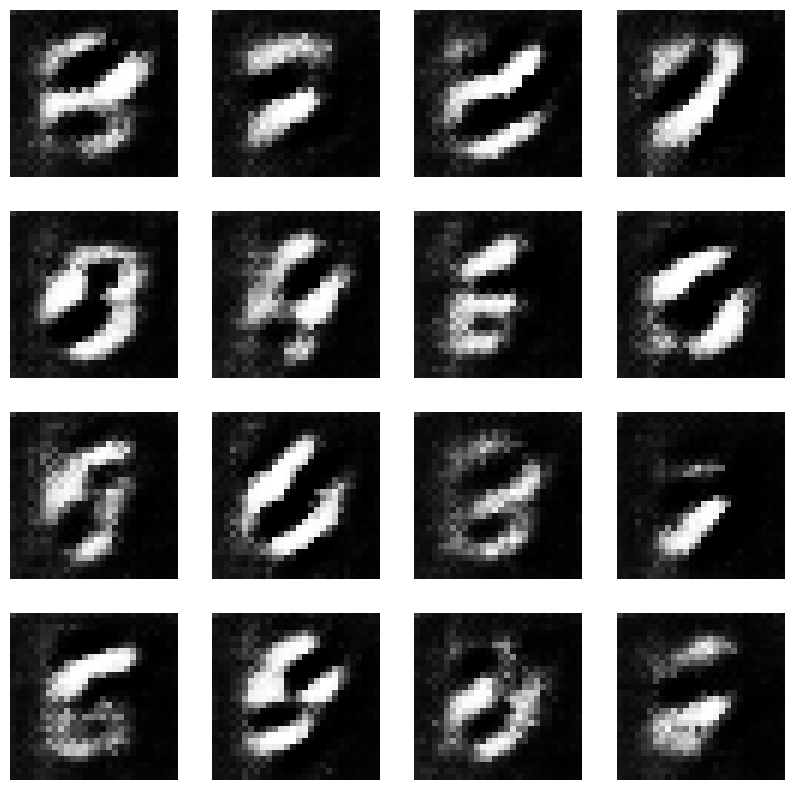

Época:  8


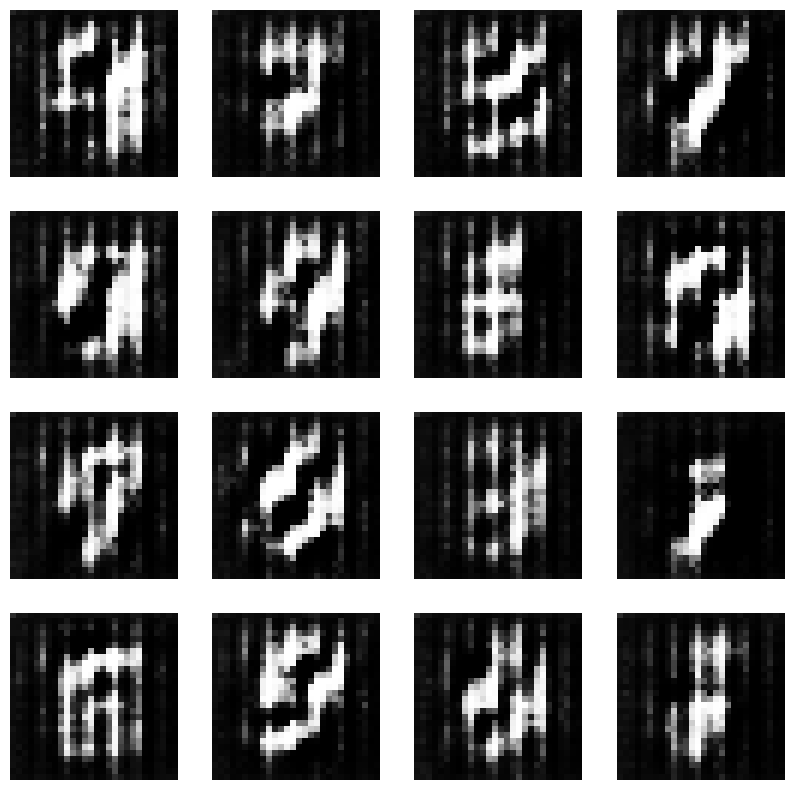

Época:  9


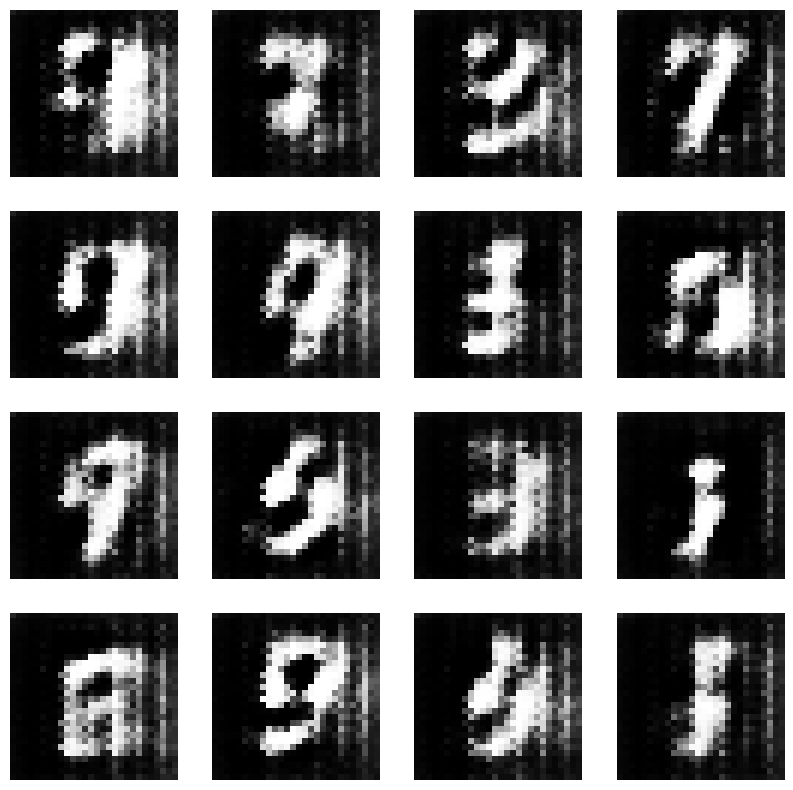

Época:  10


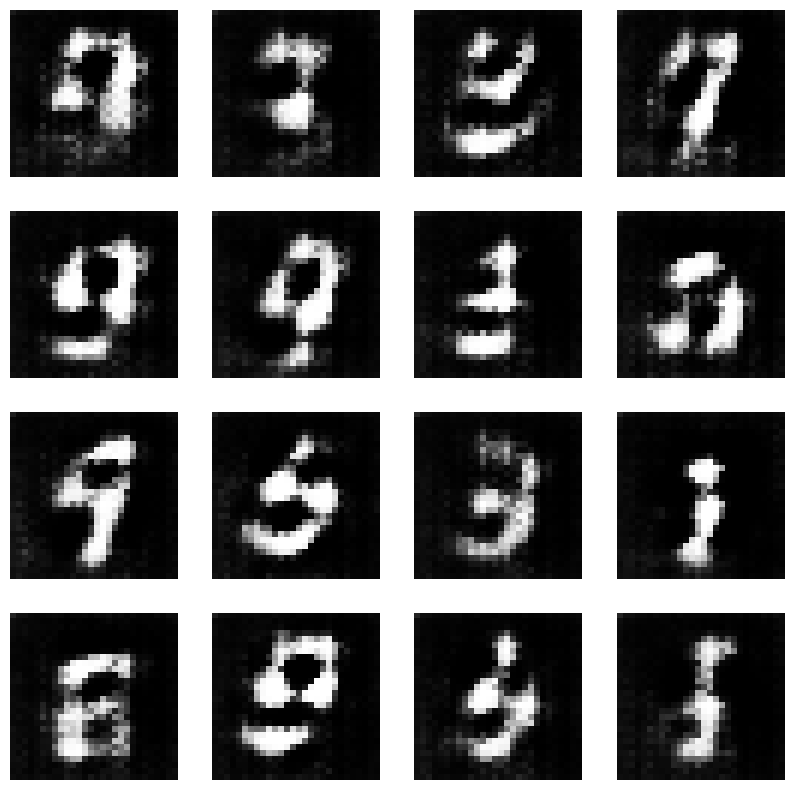

Época:  11


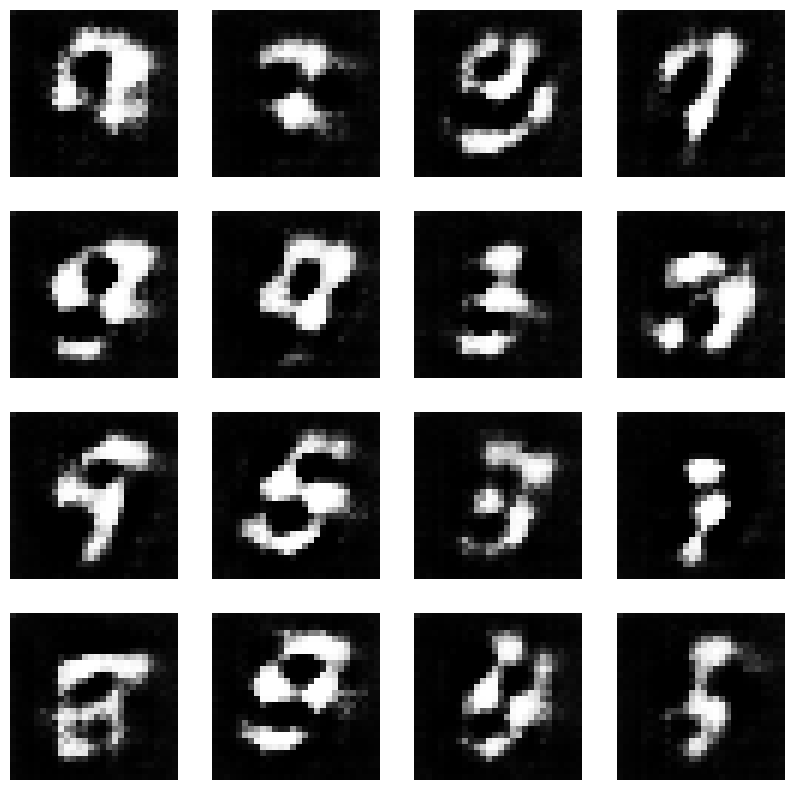

Época:  12


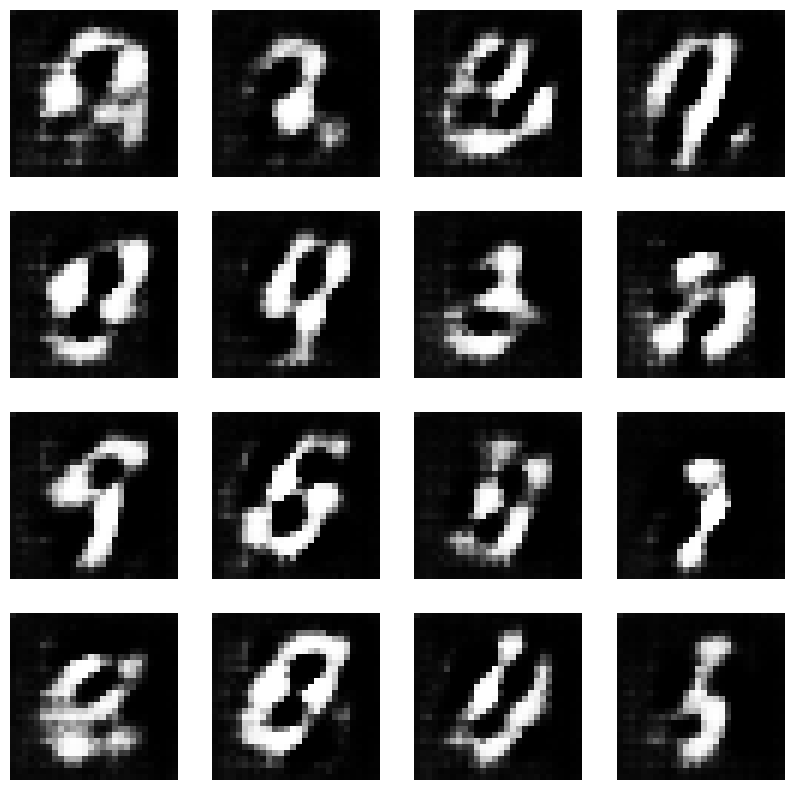

Época:  13


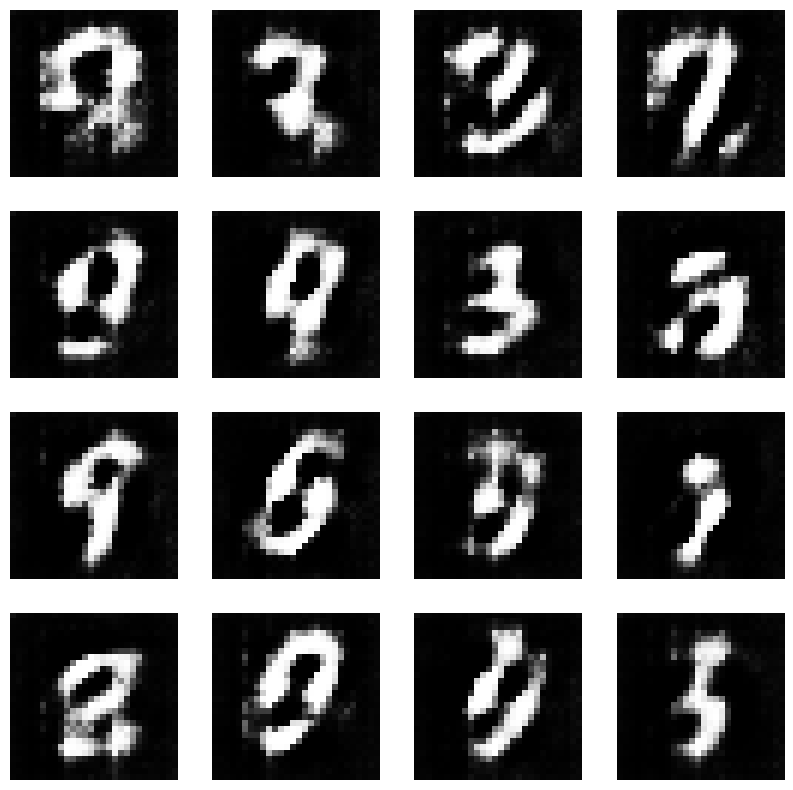

Época:  14


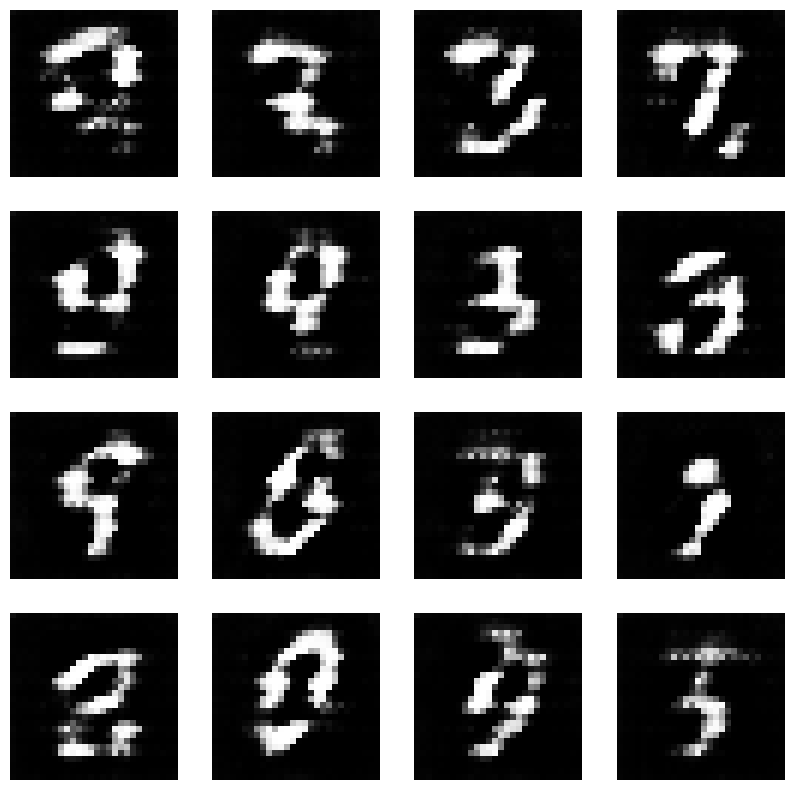

Época:  15


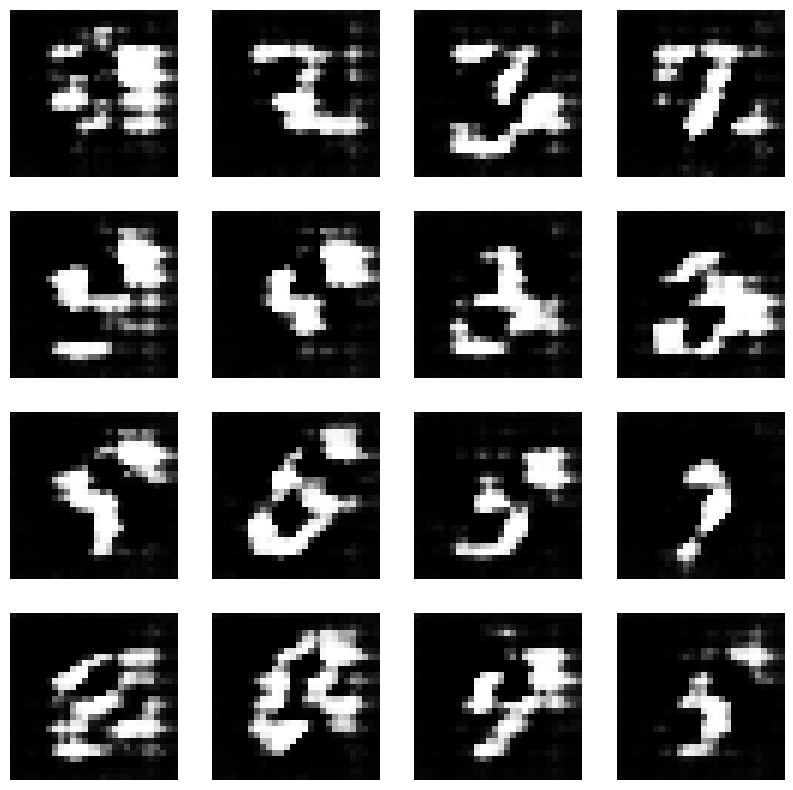

Época:  16


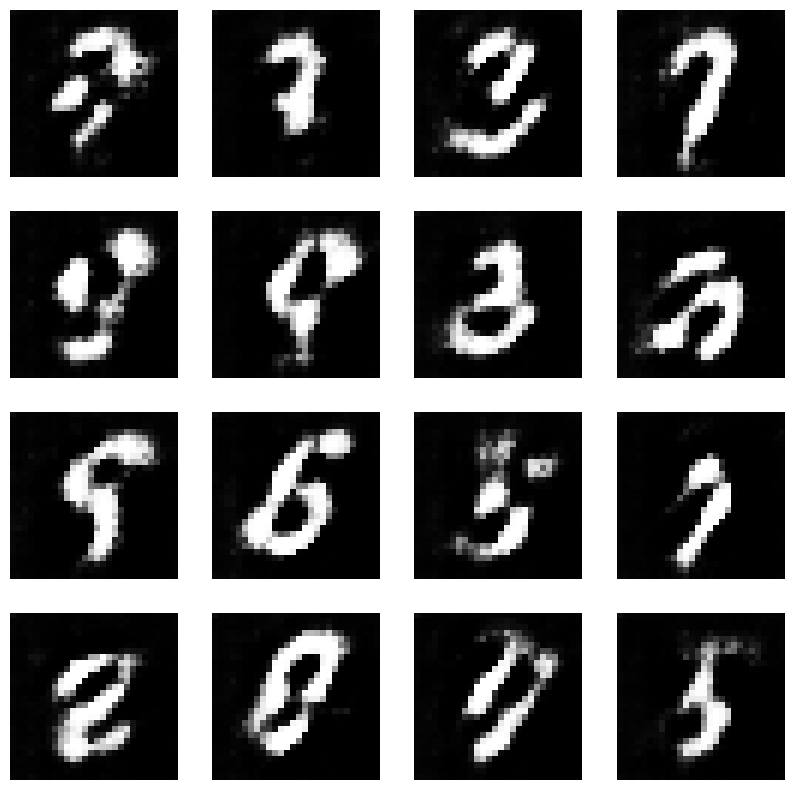

Época:  17


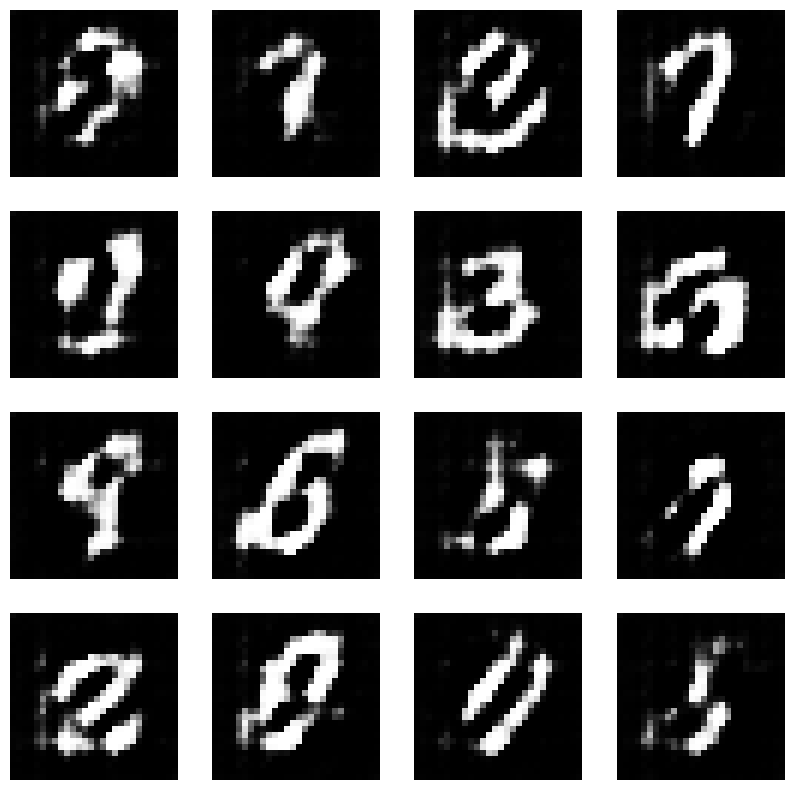

In [ ]:
treina_gan(X_treinamento, epocas, imagens_teste)